## Import Packages and Load Data Sets

In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [351]:
df_train = pd.read_csv("Data Sets/House Price Prediction/train.csv", index_col = 'Id')
df_test = pd.read_csv("Data Sets/House Price Prediction/test.csv", index_col = 'Id')

In [352]:
df_train.info() ## Investigate the datatypes 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

## Feature Preprocessing & Engineering

Since the column "MSSubClass" actually represents categories -- the datatype of int is inappropriate. "MSSubClass" should thus be changed to str.

In [353]:
df_train.MSSubClass = df_train.MSSubClass.astype(str)
df_test.MSSubClass = df_test.MSSubClass.astype(str)

Assess columns with NAs

In [354]:
df_train.columns[df_train.isna().sum() > 0]  ## columns to investigate

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [355]:
(df_train.PoolArea > 0).sum() ## this equals the number of rows with entries on the PoolQC field - can ignore na in 
                              ## PoolQC

7

All the columns except for "LotFrontage", "Electrical" and "FireplaceQu" contains NA values that signifies a feature not being present in the property not that data is missing (categorical columns will be replaced with None whereas numerical columns will be replaced with 0). Thus, NA values in these columns can be replaced. Other columns should be investigated.

In [356]:
cols_replace_na = ['Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
                   'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                   'BsmtFinType2','GarageType', 'GarageYrBlt', 
                   'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 
                   'Fence','MiscFeature']


cols_replace_na_str = df_train[cols_replace_na].columns[df_train[cols_replace_na].dtypes == 'object']
cols_replace_na_num = df_train[cols_replace_na].columns[(df_train[cols_replace_na].dtypes == 'float64')
                                                        | (df_train[cols_replace_na].dtypes == 'int64')]
                                   
df_train[cols_replace_na_str] = df_train[cols_replace_na_str].fillna(value = 'None')
df_train[cols_replace_na_num] = df_train[cols_replace_na_num].fillna(value = 0)

Repeat the same process with test set.

In [357]:
df_test[cols_replace_na_str] = df_test[cols_replace_na_str].fillna(value = 'None')
df_test[cols_replace_na_num] = df_test[cols_replace_na_num].fillna(value = 0)

Explore potentially problematic columns: LotFrontage, Eletrical and FireplaceQu

In [358]:
## Investigate rows where LotFrontage is na
df_train[df_train["LotFrontage"].isna()].head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
13,20,RL,NaN,12968,Pave,None,IR2,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,144000
15,20,RL,NaN,10920,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,GdWo,None,0,5,2008,WD,Normal,157000
17,20,RL,NaN,11241,Pave,None,IR1,Lvl,AllPub,CulDSac,...,0,None,None,Shed,700,3,2010,WD,Normal,149000
25,20,RL,NaN,8246,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,5,2010,WD,Normal,154000


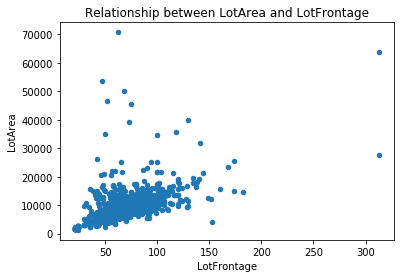

In [359]:
df_train[['LotFrontage', 'LotArea']].drop(index = 314).plot(kind = 'scatter', x = 'LotFrontage',
                                                            y = 'LotArea',
                                                            title = 'Relationship between LotArea and LotFrontage')

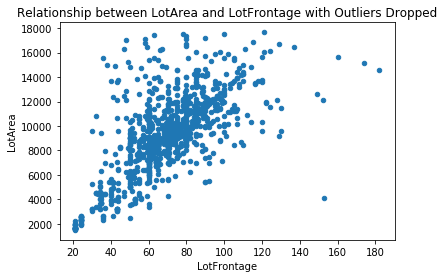

In [360]:
## Get rid of outliers and reassess the relationship between LotFrontage and LotArea 

front_lim_up = df_train['LotFrontage'].quantile(0.75)+ (1.5 * (df_train['LotFrontage'].quantile(0.75) - df_train['LotFrontage'].quantile(0.25)))
front_lim_low = df_train['LotFrontage'].quantile(0.25) - (1.5 * (df_train['LotFrontage'].quantile(0.75) - df_train['LotFrontage'].quantile(0.25)))
lot_lim_up = df_train['LotArea'].quantile(0.75) + (1.5 * (df_train['LotArea'].quantile(0.75) - df_train['LotArea'].quantile(0.25)))
lot_lim_low = df_train['LotArea'].quantile(0.25) - (1.5 * (df_train['LotArea'].quantile(0.75) - df_train['LotArea'].quantile(0.25)))

df_lot_nooutliers = df_train[(df_train['LotFrontage'] < front_lim_up) & (df_train['LotFrontage'] > front_lim_low)]
df_lot_nooutliers = df_train[(df_train['LotArea'] < lot_lim_up) &
                             (df_train['LotArea'] > lot_lim_low)].dropna(subset = ['LotFrontage'])

df_lot_nooutliers.plot(kind = 'scatter', x = 'LotFrontage', y = 'LotArea',
                       title = 'Relationship between LotArea and LotFrontage with Outliers Dropped')

There is a clear linear relationship between LotArea and LotFrontage. LotArea will, therefore, be used to predict LotFrontage for entries with missing values.

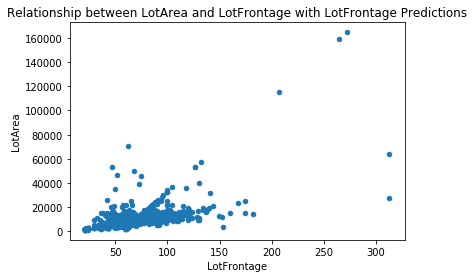

In [361]:
from sklearn.linear_model import LinearRegression

X_lot = df_train.loc[df_train[~df_train.LotFrontage.isna()].index][['LotArea']]
y_lot = df_train.loc[df_train[~df_train.LotFrontage.isna()].index][['LotFrontage']]
X_lot_predict = df_train.loc[df_train[df_train.LotFrontage.isna()].index][['LotArea']]

lin_reg_lot = LinearRegression()
lin_reg_lot.fit(df_train.dropna(subset = ['LotFrontage'])[['LotArea']],
                df_train.dropna(subset = ['LotFrontage'])[['LotFrontage']])
y_lot_predict_train = lin_reg_lot.predict(X_lot_predict)
y_lot_predict_test = lin_reg_lot.predict(df_test[df_test.LotFrontage.isna()][['LotArea']])

df_train.loc[df_train.LotFrontage.isna(), 'LotFrontage'] = y_lot_predict_train 
df_test.loc[df_test.LotFrontage.isna(), 'LotFrontage'] = y_lot_predict_test



df_train.drop(index = 314).plot(kind = 'scatter', x = 'LotFrontage', y= 'LotArea',
                               title = 'Relationship between LotArea and LotFrontage with LotFrontage Predictions')


In [362]:
## Investigate rows where Electrical is na
df_train[df_train["Electrical"].isna()].head()
df_test[df_test["Electrical"].isna()].head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,


There are no cases where Electrical is na in test set, therefore the row where Eletrical is na in training set can be dropped.


In [363]:
df_train = df_train.dropna(axis = 0, subset =['Electrical'])

In [364]:
## Explore rows where FireplaceQu is na

df_train[df_train.FireplaceQu.isna()].count()[0]

689

In [365]:
(df_train.Fireplaces == 0).sum()

689

Rows where FireplaceQu is na can be replaced by th string 'None'.

In [366]:
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna(value = 'None')
df_test['FireplaceQu'] = df_test['FireplaceQu'].fillna(value = 'None')

In [367]:
(df_train.isna().sum() > 0).sum

<bound method Series.sum of MSSubClass       False
MSZoning         False
LotFrontage      False
LotArea          False
Street           False
                 ...  
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
SalePrice        False
Length: 80, dtype: bool>

## Model Selection & Model Fitting

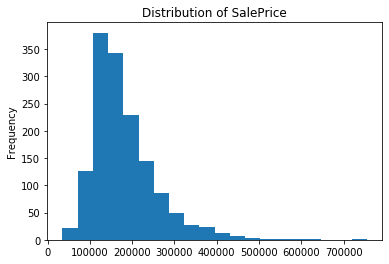

In [368]:
df_train.SalePrice.plot(kind = 'hist', bins = 20, title = 'Distribution of SalePrice')

In [369]:
pd.get_dummies(df_train).columns[(pd.get_dummies(df_train).corr().SalePrice > 0.3)] ## Features with high correlation 
                                                                                    ## with SalePrice

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'SalePrice', 'MSSubClass_60',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Exterior1st_VinylSd',
       'Exterior2nd_VinylSd', 'MasVnrType_Stone', 'ExterQual_Ex',
       'ExterQual_Gd', 'Foundation_PConc', 'BsmtQual_Ex', 'BsmtExposure_Gd',
       'BsmtFinType1_GLQ', 'HeatingQC_Ex', 'KitchenQual_Ex', 'KitchenQual_Gd',
       'FireplaceQu_Gd', 'GarageType_Attchd', 'GarageFinish_Fin',
       'SaleType_New', 'SaleCondition_Partial'],
      dtype='object')

Test features above with a simple ML model. 

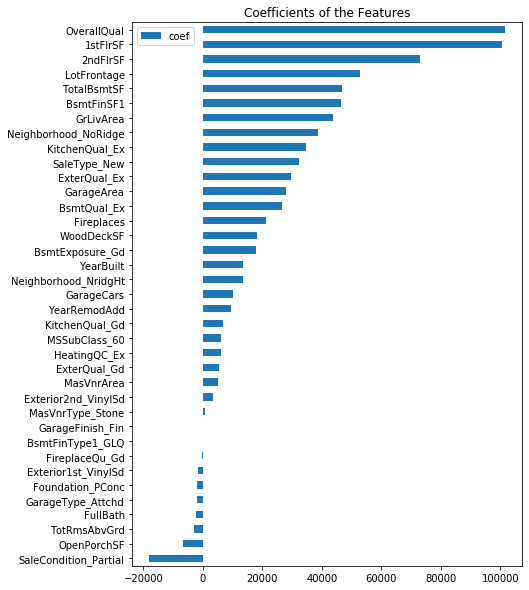

In [370]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

high_corr_cols = ['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'MSSubClass_60',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Exterior1st_VinylSd',
       'Exterior2nd_VinylSd', 'MasVnrType_Stone', 'ExterQual_Ex',
       'ExterQual_Gd', 'Foundation_PConc', 'BsmtQual_Ex', 'BsmtExposure_Gd',
       'BsmtFinType1_GLQ', 'HeatingQC_Ex', 'KitchenQual_Ex', 'KitchenQual_Gd',
       'FireplaceQu_Gd', 'GarageType_Attchd', 'GarageFinish_Fin',
       'SaleType_New', 'SaleCondition_Partial']

df_temp_train = pd.get_dummies(df_train)[high_corr_cols + ['SalePrice']]
scaler_ = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(df_temp_train[high_corr_cols], 
                                                    df_temp_train[['SalePrice']])

scaler_.fit(X_train)
X_train = scaler_.transform(X_train)
X_test = scaler_.transform(X_test)

lasso_ = Lasso(max_iter = 10000) ## max_iter set to 10000 as default val is not high enough for GD to determine weights
lasso_.fit(X_train, y_train)
df_coef_ = pd.DataFrame(index = high_corr_cols, data = {'coef': lasso_.coef_})
df_coef_.sort_values(by = 'coef', ascending = True).plot(kind = 'barh', figsize =(7,10),
                                                         title = 'Coefficients of the Features')

In [371]:
from sklearn.metrics import r2_score

y_pred = lasso_.predict(X_test)
r2_score(y_test, y_pred)

0.6810296257052029

It's clear that the model can, to a certain extent, predict SalePrice. Improvements can be made to further increase the accuracy of the model.

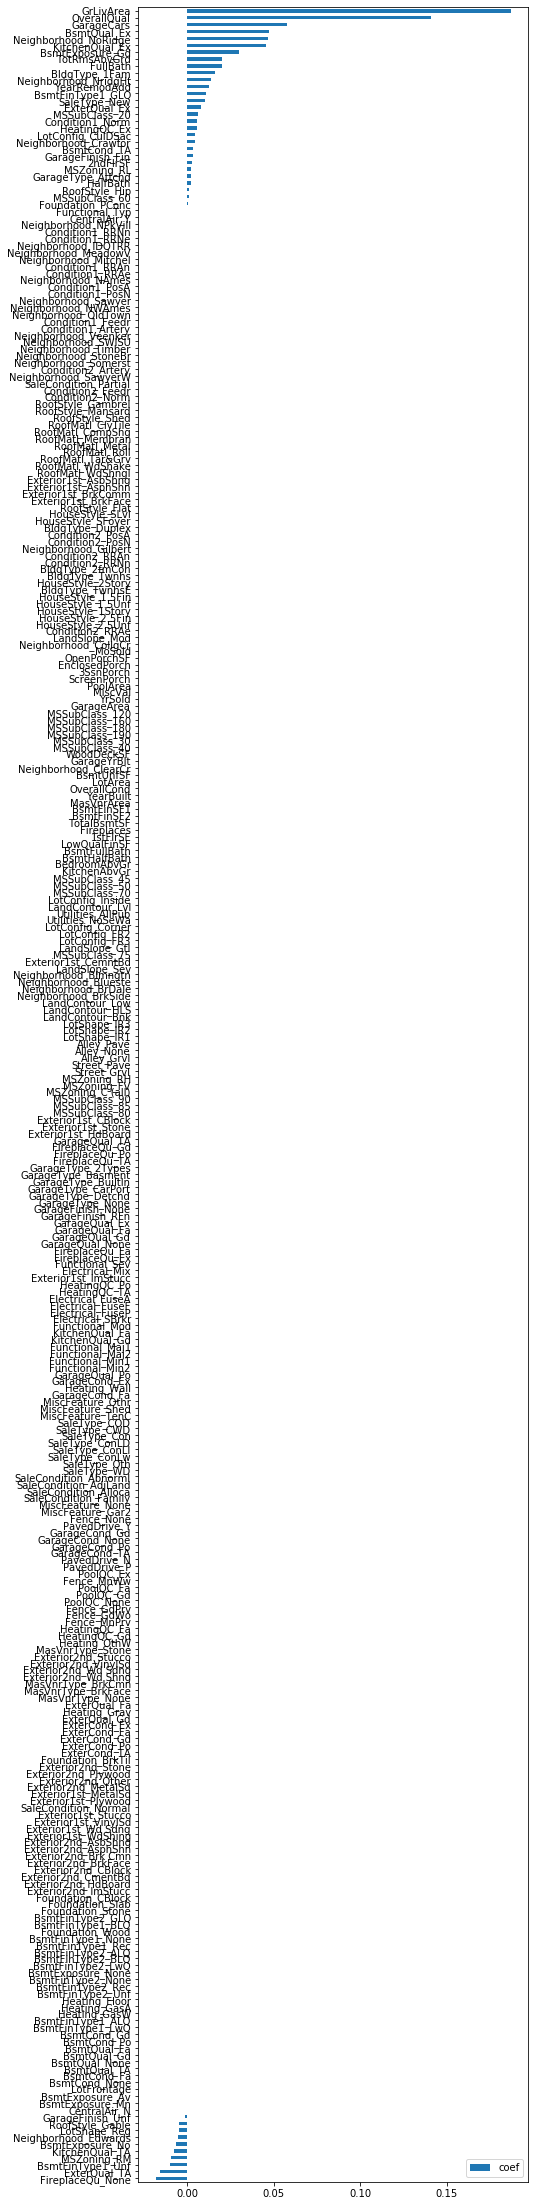

In [372]:
from sklearn.linear_model import Lasso

## Use Lasso's reguralization to determine best features to utilize 
lasso_reg = Lasso(max_iter = 10000, alpha = 0.001)  ## max_iter set to 10000 as default val is not high enough for GD to determine weights
scaler_reg_X = MinMaxScaler()
scaler_reg_y = MinMaxScaler()
X_reg = scaler_reg_X.fit_transform(pd.get_dummies(df_train).drop(columns = ['SalePrice']))
y_reg = scaler_reg_y.fit_transform(df_train[['SalePrice']])
lasso_reg.fit(X_reg, y_reg)
df_coef = pd.DataFrame(index = pd.get_dummies(df_train).drop(columns = ['SalePrice'])
                       .columns.to_list(),
                       data = {"coef": lasso_reg.coef_}).sort_values(by = 'coef').plot(kind = 'barh', figsize = (7,40))


Get columns with high coef as determined by L1 regularization.

In [373]:
reg_cols = pd.get_dummies(df_train).drop(columns = ['SalePrice']).columns[(
    (lasso_reg.coef_ > 0) | (lasso_reg.coef_ < 0))]


Get the original name of the columns prior to encoding.

In [374]:
reg_cols_preen = []

for col in reg_cols:
    reg_cols_preen.append(col.split('_')[0])
    
reg_cols_preen = list(set(reg_cols_preen))
reg_cols_preen

['RoofStyle',
 'GrLivArea',
 'LotShape',
 'TotRmsAbvGrd',
 'GarageCars',
 'BsmtQual',
 'BldgType',
 'ExterQual',
 'Foundation',
 'SaleType',
 'YearRemodAdd',
 'HalfBath',
 'HeatingQC',
 'GarageType',
 'LotConfig',
 'GarageFinish',
 'FullBath',
 'Condition1',
 'BsmtExposure',
 'CentralAir',
 '2ndFlrSF',
 'MSSubClass',
 'OverallQual',
 'MSZoning',
 'Functional',
 'FireplaceQu',
 'KitchenQual',
 'BsmtFinType1',
 'BsmtCond',
 'Neighborhood']

Normalize all the features fields using MinMaxScaler.

In [375]:
scaler_X = MinMaxScaler()
df_train_dum_norm = scaler_X.fit_transform(pd.get_dummies(df_train[reg_cols_preen]))

## Hyperparameter Tuning & Model Selection

In [376]:
from sklearn.model_selection import GridSearchCV

params = {'alpha': (1, 10, 50, 75, 100, 200, 300),
          'max_iter': (3000, 10000, 50000)
         }
lasso = Lasso()
clf = GridSearchCV(lasso, params, cv = 5)
clf.fit(df_train_dum_norm, df_train['SalePrice'])
pd.DataFrame(index = clf.cv_results_['params'],
             data = {'MeanScore': clf.cv_results_['mean_test_score']}
            ).sort_values(by = 'MeanScore', ascending = False)

,MeanScore
"{'alpha': 100, 'max_iter': 50000}",0.851702
"{'alpha': 100, 'max_iter': 3000}",0.851702
"{'alpha': 100, 'max_iter': 10000}",0.851702
"{'alpha': 200, 'max_iter': 50000}",0.851180
"{'alpha': 200, 'max_iter': 10000}",0.851180
"{'alpha': 200, 'max_iter': 3000}",0.851180
"{'alpha': 75, 'max_iter': 10000}",0.850150
"{'alpha': 75, 'max_iter': 3000}",0.850150
"{'alpha': 75, 'max_iter': 50000}",0.850150
"{'alpha': 50, 'max_iter': 3000}",0.847867


## Prediction Preparation

Investigate test features that will be used for the predictive model that contain NAs.

In [377]:
test_na_cols = [x for x in df_test.columns[df_test.isna().sum() > 0].to_list() for y in reg_cols_preen if x in y ]
test_na_cols

['MSZoning', 'KitchenQual', 'Functional', 'GarageCars', 'SaleType']

In [378]:
df_test.loc[((df_test['MSZoning'].isna())
            | (df_test['Functional'].isna())
            | (df_test['KitchenQual'].isna())
            | (df_test['GarageCars'].isna())
            | (df_test['SaleType'].isna())
            ), :]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1556,50,RL,72.000000,10632,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,1,2010,COD,Normal
1916,30,NaN,109.000000,21780,Grvl,None,Reg,Lvl,NaN,Inside,...,0,0,None,None,None,0,3,2009,ConLD,Normal
2217,20,NaN,80.000000,14584,Pave,None,Reg,Low,AllPub,Inside,...,0,0,None,None,None,0,2,2008,WD,Abnorml
2251,70,NaN,130.963254,56600,Pave,None,IR1,Low,AllPub,Inside,...,0,0,None,None,None,0,1,2008,WD,Normal
2474,50,RM,60.000000,10320,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,84,0,None,None,None,0,9,2007,COD,Abnorml
2490,20,RL,85.000000,13770,Pave,None,Reg,Lvl,AllPub,Corner,...,0,0,None,None,None,0,10,2007,NaN,Normal
2577,70,RM,50.000000,9060,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,MnPrv,None,0,3,2007,WD,Alloca
2905,20,NaN,125.000000,31250,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,5,2006,WD,Normal


Explore 'MSZoning', 'KitchenQual', 'Functional', 'GarageCars' and 'SaleType'

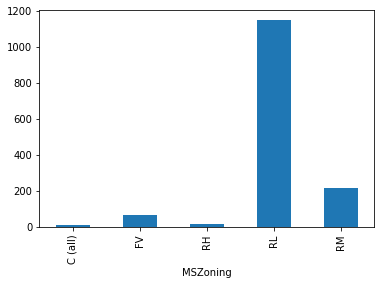

In [379]:
df_train.groupby(by = 'MSZoning').count()['SalePrice'].plot(kind = 'bar')

Replace NAs in MSZoning in the test set with the most common class in training set. 

In [380]:
df_test.MSZoning = df_test.MSZoning.fillna(value = 'RL')
df_test.MSZoning.isna().sum()

0

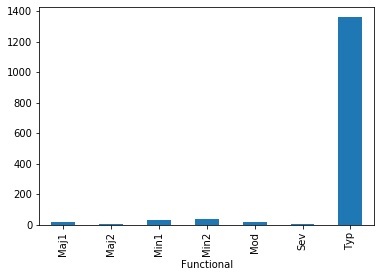

In [381]:
df_train.groupby(by = 'Functional').count()['SalePrice'].plot(kind = 'bar')

Replace NAs in Functional in the test set with the most common class in training set. 

In [382]:
df_test.Functional = df_test.MSZoning.fillna(value = 'Typ')
df_test.Functional.isna().sum()

0

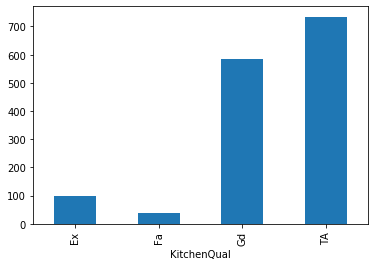

In [383]:
df_train.groupby(by = 'KitchenQual').count()['SalePrice'].plot(kind = 'bar')

In [384]:
df_test.KitchenQual = df_test.MSZoning.fillna(value = 'TA')
df_test.KitchenQual.isna().sum()

0

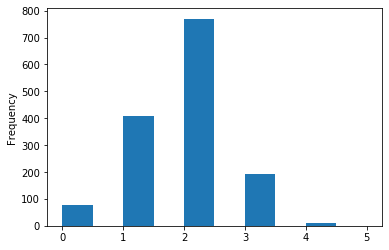

In [385]:
df_test.GarageCars.plot(kind = 'hist')

Replace NAs in GarageCars in the test set with the median value from the training set.

In [386]:
df_test.GarageCars = df_test.GarageCars.fillna(value = 2.0)
df_test.GarageCars.isna().sum()

0

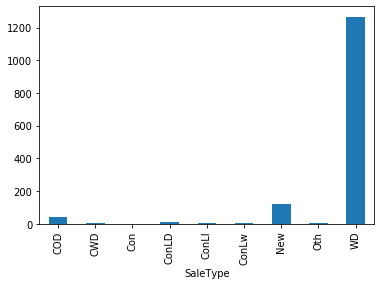

In [387]:
df_train.groupby(by = 'SaleType').count()['SalePrice'].plot(kind = 'bar')

In [388]:
df_test.SaleType = df_test.SaleType.fillna(value = 'WD')
df_test.SaleType.isna().sum()

0

## Fit Model and Make Final Prediction

In [389]:
## Get common columns after get_dummies from training and test set
common_cols = [X for X in pd.get_dummies(df_test[reg_cols_preen]).columns if X in pd.get_dummies(df_train[reg_cols_preen]).columns]

In [390]:
scaler_X_fin = MinMaxScaler()
X_train_fin = scaler_X_fin.fit_transform(pd.get_dummies(df_train)[common_cols])
X_test_fin = scaler_X_fin.transform(pd.get_dummies(df_test)[common_cols])

In [392]:
lasso_fin = Lasso(alpha = 100, max_iter = 50000)
lasso_fin.fit(X_train_fin, df_train['SalePrice'])
predictions = lasso_fin.predict(X_test_fin)
results_df = pd.DataFrame(index =  df_test.index, data ={'SalePrice': predictions})

results_df.to_csv(r'C:\Users\g36e3.000\Documents\Python Scripts\Predictions\house_price.csv')

